# Prédiction du prix du loyer
Dataset: https://www.kaggle.com/datasets/denkuznetz/housing-prices-regression/data

Ce notebook introduit  un cas pratique d'utilisation de  régression linéaire pour la prévision des prix de location. Les valeurs observées (utilisées pour faire la prédiction) sont les suivantes :
- pieds_carres
- nombre_chambres
- nombre_douches
- annee_construction
- avec_jardin
- avec_piscine
- taille_garage
- score_localisation
- distance_centre_ville

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import time
from sklearn.preprocessing import StandardScaler
import random
import joblib

## Numpy
Bibliothèque de calcul numérique sur les matrices.

In [ ]:
#Créer une matrice de dimension 3 X 4 avec des valeurs aléatoires
matrice_1=np.random.rand(3,4)
print(matrice_1)

[[0.15941364 0.35148047 0.55276477 0.77426005]
 [0.82375594 0.74300842 0.3939548  0.3174541 ]
 [0.92425868 0.02005392 0.27054148 0.645243  ]]


In [ ]:
#Création d'une matrice
print('\n')
M1=np.array([
    [12,14,45],[10,5,3]
])
print(f'Matrice 1')
print(M1)

print('\n')

M2=np.array([
    [1,8.0,12],[11,56,73]
])
print(f'Matrice 2')
print(M2)

print('\n')

M3=np.array([
    [2.3,8.0,12],[10.7,9.6,73],[5.7,12,7.4]
])
print(f'Matrice 3')
print(M3)


print('\n')


print(f'Matrice 1 + Matrice 2')
print(M1 + M2)

print('\n')

print(f'Matrice 1 + Matrice 2')
print(M1 * M2)

print('\n')

print(f'Matrice 1 @ Matrice 3')
print(M1@M3)


print('\n')

print(f'2 x Matrice 1')
print(2*M1)



Matrice 1
[[12 14 45]
 [10  5  3]]


Matrice 2
[[ 1.  8. 12.]
 [11. 56. 73.]]


Matrice 3
[[ 2.3  8.  12. ]
 [10.7  9.6 73. ]
 [ 5.7 12.   7.4]]


Matrice 1 + Matrice 2
[[13. 22. 57.]
 [21. 61. 76.]]


Matrice 1 + Matrice 2
[[ 12. 112. 540.]
 [110. 280. 219.]]


Matrice 1 @ Matrice 3
[[ 433.9  770.4 1499. ]
 [  93.6  164.   507.2]]


2 x Matrice 1
[[24 28 90]
 [20 10  6]]


## Excercices
Calculer
-  $M_2+M3$
-  $\alpha * M2$
-  $M_1@M2$
$$
M_1=\begin{bmatrix}
12.5 & 5.5 & 3.2 \\
7.2 & 6.8 & 2.9 
\end{bmatrix} ; 
M_2=\begin{bmatrix}
23.3 & 4.2 & 5.6 \\
3.3 & 2.5 & 9.6 \\
12.3 & 4.7 & 7.6 
\end{bmatrix} ; 
M_3=\begin{bmatrix}
10.7 & 6.8 & 4.9 \\
45.8 & 10.4 & 12 \\
3.8 & 2.6 & 2.1 
\end{bmatrix} ;\alpha=2
$$

## Pandas
Permet de manipuler des données structurées.

In [ ]:
data=pd.read_csv('src/data1.csv')#Lire le fichier csv.
data.head()#Affiche les 5 premières lignes du dataframe.

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386
2,3,232.998485,1,3,2,1923,1,0,14,2.911442,6.904599,464478.696880
3,4,199.664621,5,2,2,1918,0,0,17,2.070949,8.284019,583105.655996
4,5,89.004660,4,3,3,1999,1,0,34,1.523278,14.648277,619879.142523


In [ ]:
#Renommer les colonnes en français
nouveaux_noms_colonnes={
    "Square_Feet":"pieds_carres",#Evitez de nommer les colonnes comme suit: pieds carrés
    "Num_Bedrooms":"nombre_chambres",
    "Num_Bathrooms":"nombre_douches",
    "Num_Floors":"nombre_etages",
    "Year_Built":"annee_construction",
    "Has_Garden":"avec_jardin",
    "Has_Pool":"avec_piscine",
    "Garage_Size":"taille_garage",
    "Location_Score":"score_localisation",
    "Distance_to_Center":"distance_centre_ville",
    "Price":"prix"
}

data.rename(columns=nouveaux_noms_colonnes,inplace=True)
#Inplace permet de modifier directement le dataframe. Sa valeur par défaut est False.
#Si vous auriez défini inplace à False vous auriez   réaffecter la valeur data comme ci-dessous.
# data=data.rename(columns=nouveaux_noms_colonnes,inplace=False)
data.head(2)

,ID,pieds_carres,nombre_chambres,nombre_douches,nombre_etages,annee_construction,avec_jardin,avec_piscine,taille_garage,score_localisation,distance_centre_ville,prix
0,1,143.635030,1,3,3,1967,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,1949,0,1,37,6.061466,10.827392,591425.135386


In [ ]:
print(f'Colonnes du dataframe -> {data.columns}')
print(type(data.columns))
print('\n')
colonnes=data.columns.to_list()
print(f'Colonnes du dataframe en format liste-> {colonnes}')
print(type(colonnes))

Colonnes du dataframe -> Index(['ID', 'pieds_carres', 'nombre_chambres', 'nombre_douches',
       'nombre_etages', 'annee_construction', 'avec_jardin', 'avec_piscine',
       'taille_garage', 'score_localisation', 'distance_centre_ville', 'prix'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>


Colonnes du dataframe en format liste-> ['ID', 'pieds_carres', 'nombre_chambres', 'nombre_douches', 'nombre_etages', 'annee_construction', 'avec_jardin', 'avec_piscine', 'taille_garage', 'score_localisation', 'distance_centre_ville', 'prix']
<class 'list'>


In [ ]:
data.info()#Info sur les colonnes/observations/features et sur le dataframe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     500 non-null    int64  
 1   pieds_carres           500 non-null    float64
 2   nombre_chambres        500 non-null    int64  
 3   nombre_douches         500 non-null    int64  
 4   nombre_etages          500 non-null    int64  
 5   annee_construction     500 non-null    int64  
 6   avec_jardin            500 non-null    int64  
 7   avec_piscine           500 non-null    int64  
 8   taille_garage          500 non-null    int64  
 9   score_localisation     500 non-null    float64
 10  distance_centre_ville  500 non-null    float64
 11  prix                   500 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 47.0 KB


In [ ]:
#Convertir les dates en durée en fonction de la date la plus récente.
max_date=data.annee_construction.max()
print(f'maximum date {max_date}')
data['annee_construction']=data['annee_construction'].apply(lambda x: max_date-x)
data.head(2)


maximum date 2022


,ID,pieds_carres,nombre_chambres,nombre_douches,nombre_etages,annee_construction,avec_jardin,avec_piscine,taille_garage,score_localisation,distance_centre_ville,prix
0,1,143.635030,1,3,3,55,1,1,48,8.297631,5.935734,602134.816747
1,2,287.678577,1,2,1,73,0,1,37,6.061466,10.827392,591425.135386


In [ ]:
#Diviser les prix par 100000 pour avoir des valeurs plus petites.
data['prix']=data['prix'].apply(lambda x: x/10000)
data.head(2)

,ID,pieds_carres,nombre_chambres,nombre_douches,nombre_etages,annee_construction,avec_jardin,avec_piscine,taille_garage,score_localisation,distance_centre_ville,prix
0,1,143.635030,1,3,3,55,1,1,48,8.297631,5.935734,60.213482
1,2,287.678577,1,2,1,73,0,1,37,6.061466,10.827392,59.142514


Changons le type de données des colonnes catégorielles/discrètes listé ci-dessous  en type object pour des raisons d'études statistiques: 
- avec_jardin
- avec_piscine
- annee_construction

In [ ]:
data[['avec_jardin','avec_piscine']]=data[['avec_jardin','avec_piscine']].astype(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     500 non-null    int64  
 1   pieds_carres           500 non-null    float64
 2   nombre_chambres        500 non-null    int64  
 3   nombre_douches         500 non-null    int64  
 4   nombre_etages          500 non-null    int64  
 5   annee_construction     500 non-null    int64  
 6   avec_jardin            500 non-null    object 
 7   avec_piscine           500 non-null    object 
 8   taille_garage          500 non-null    int64  
 9   score_localisation     500 non-null    float64
 10  distance_centre_ville  500 non-null    float64
 11  prix                   500 non-null    float64
dtypes: float64(4), int64(6), object(2)
memory usage: 47.0+ KB


In [ ]:
data.describe()#Statistique des données numériques.

,ID,pieds_carres,nombre_chambres,nombre_douches,nombre_etages,annee_construction,taille_garage,score_localisation,distance_centre_ville,prix
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,174.640428,2.958000,1.976000,1.964000,64.396000,30.174000,5.164410,10.469641,58.220963
std,144.481833,74.672102,1.440968,0.820225,0.802491,35.491781,11.582575,2.853489,5.588197,12.227339
min,1.000000,51.265396,1.000000,1.000000,1.000000,0.000000,10.000000,0.004428,0.062818,27.689247
25%,125.750000,110.319923,2.000000,1.000000,1.000000,34.000000,20.000000,2.760650,6.066754,50.308034
50%,250.500000,178.290937,3.000000,2.000000,2.000000,63.000000,30.000000,5.206518,10.886066,57.472411
75%,375.250000,239.031220,4.000000,3.000000,3.000000,96.000000,41.000000,7.732933,15.072590,66.594230
max,500.000000,298.241199,5.000000,3.000000,3.000000,122.000000,49.000000,9.995439,19.927966,96.067827


In [ ]:
data.describe(include=['object'])#Statistique des données catégorielles.

,avec_jardin,avec_piscine
count,500,500
unique,2,2
top,1,0
freq,268,254


In [ ]:
data.duplicated().values.any()#Vérifier si il y a des linges qui se répètent (doublons/duplicates).

np.False_

In [ ]:
data.isnull().values.any()#Vérifier si le dataframe contient des valeurs manquantes, généralement marquées comme NAN.

np.False_

Les valeurs manquantes peuvent être remplacées par :
- La moyenne. Example $[2,NAN,10]$->$[2,6,10]$; 
- La médiane;
- Le mode (valeurs catégorielles)
- Ou des méthodes plus avancées 

Supposons que des valeurs soient manquantes dans la colonne « pieds carrés ». Nous aurions remplacé ces valeurs comme ci-dessous.

In [ ]:
_ = data[['pieds_carres']].fillna(data[['pieds_carres']].mean(numeric_only=True))#Undescore est généralement utilisé pour nommer une variable que l'on ne souhaite pas utilisée.

## Matplotlib & Seaborn
Bibliothèques de visualisation

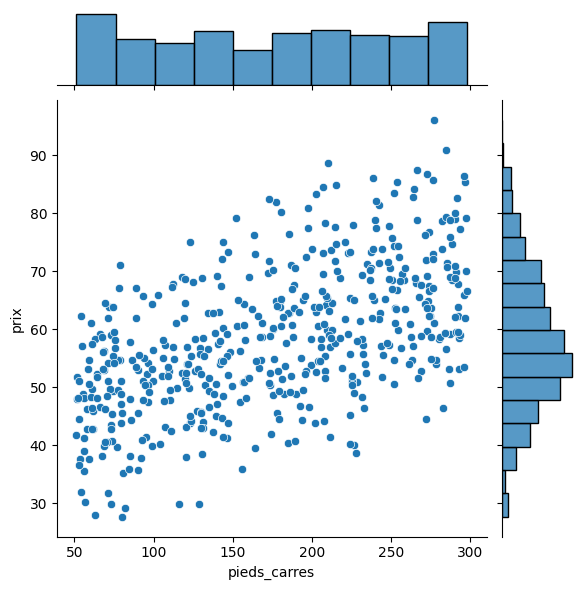

In [ ]:
sns.jointplot(x="pieds_carres",y="prix",data=data)

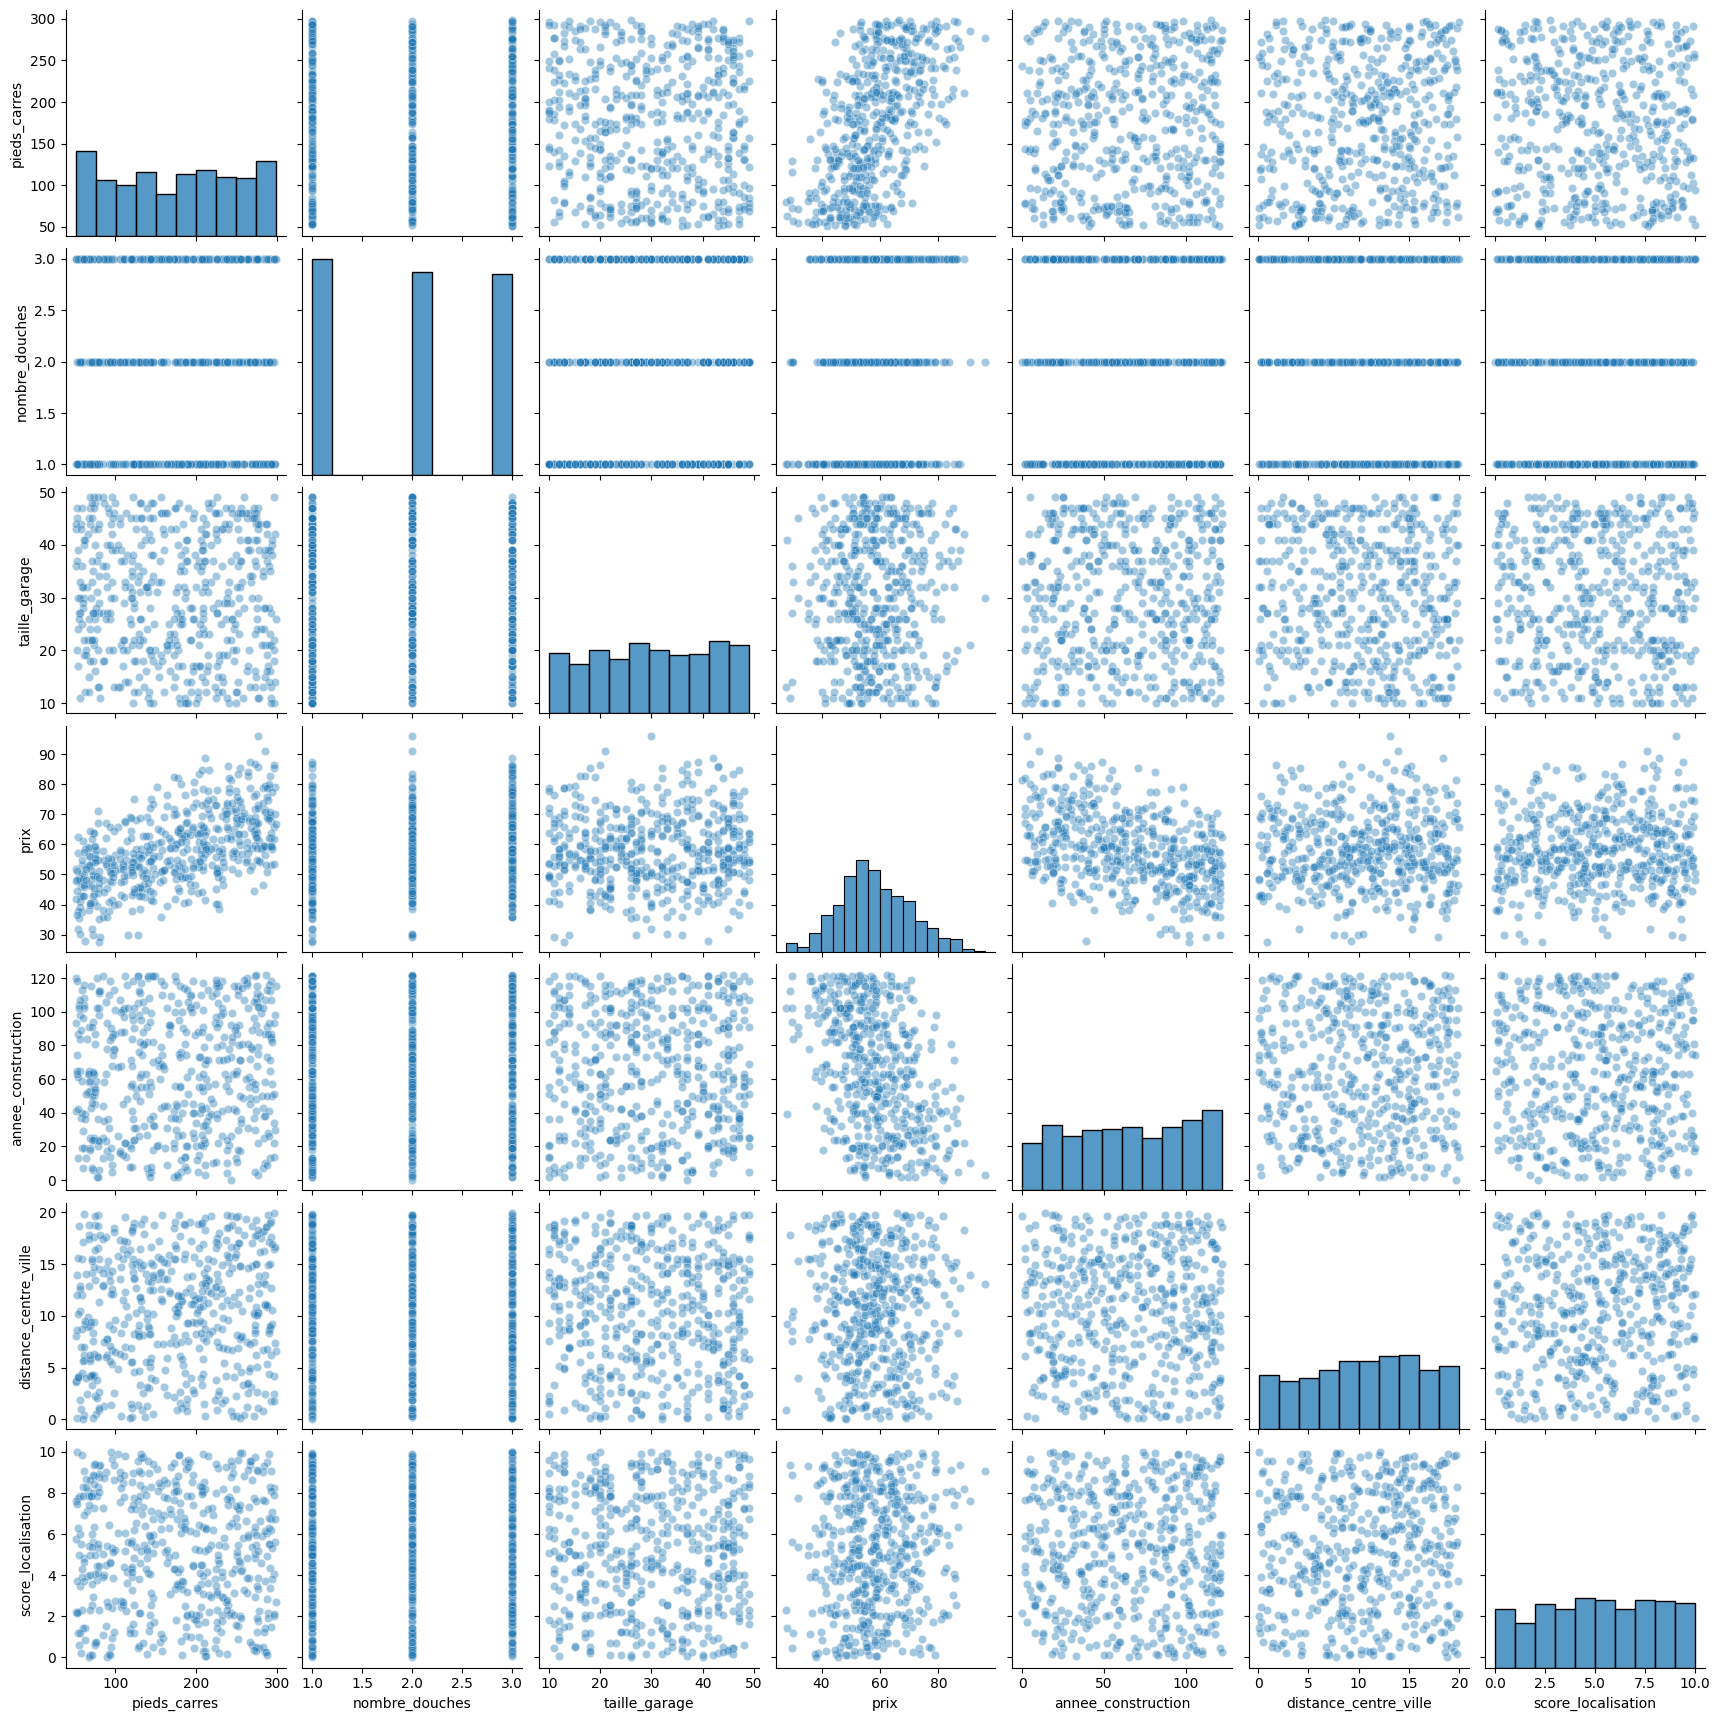

In [ ]:
sns.pairplot(data[['pieds_carres','nombre_douches','taille_garage','prix','annee_construction','distance_centre_ville','score_localisation']],kind='scatter',plot_kws={"alpha":0.4})

In [ ]:
#Supprimons les valeurs catégorielles
colonnes.remove('ID')
colonnes.remove('avec_piscine')
colonnes.remove('avec_jardin')

In [ ]:
colonnes

['pieds_carres',
 'nombre_chambres',
 'nombre_douches',
 'nombre_etages',
 'annee_construction',
 'taille_garage',
 'score_localisation',
 'distance_centre_ville',
 'prix']

Colonnes choisies -> ['taille_garage', 'score_localisation', 'distance_centre_ville', 'nombre_chambres']


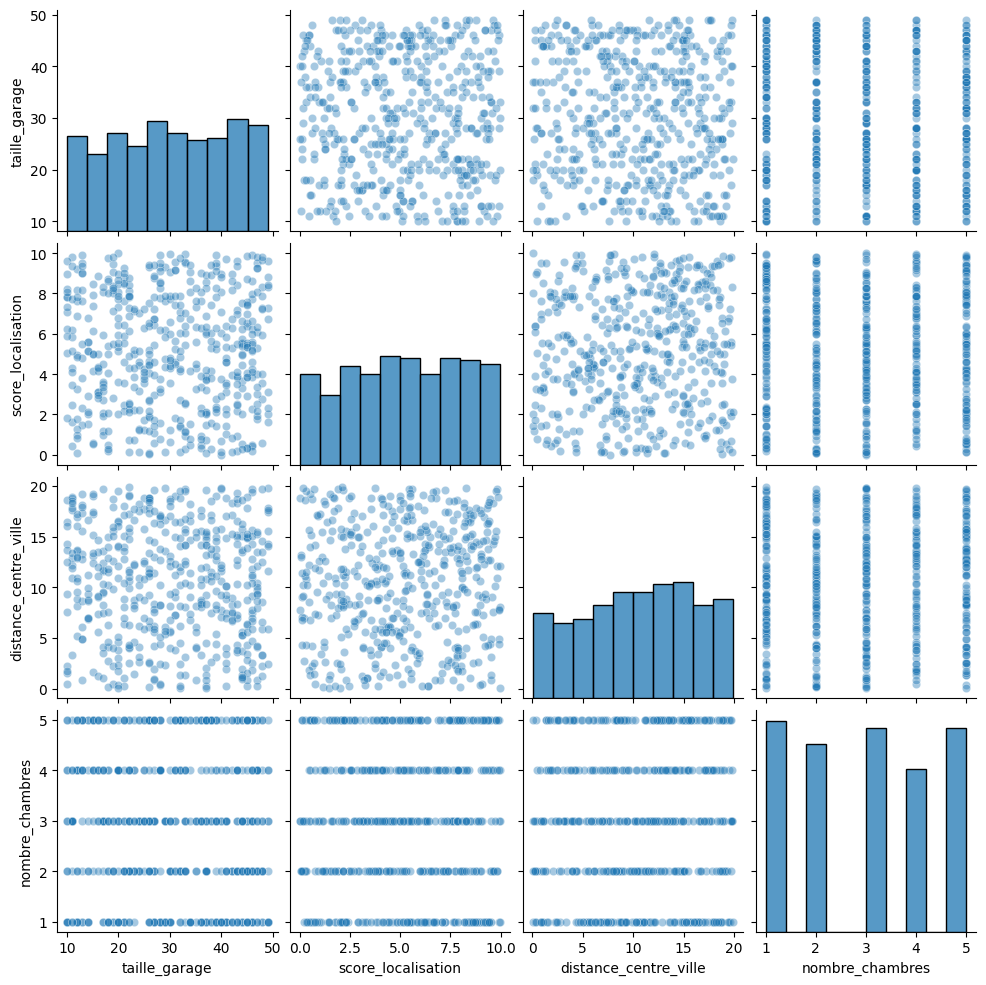

In [ ]:
#Selectionner au hasard les colonnes que vous voulez analyser.
random_colonnes=random.sample(colonnes,k=4)
print(f'Colonnes choisies -> {random_colonnes}')
sns.pairplot(data[random_colonnes],kind='scatter',plot_kws={"alpha":0.4})

## Entraînement du modèle avec Scikit-learn

Division des données. Une partie pour l'entraînement, une partie pour l'évaluation du modèle (également appelée test du modèles).

In [ ]:
# observations=['pieds_carres','nombre_chambres','nombre_etages','distance_centre_ville','annee_construction','taille_garage','score_localisation','avec_piscine']
observations=['pieds_carres','nombre_chambres','nombre_etages','distance_centre_ville']


X=data[observations].values#Observations

print('Example des observations/features avant la standardization.')
print(X[0])

scaler = StandardScaler()
X_ = scaler.fit_transform(X)
print('\n')
print('Example des observations/features après la standardization.')
print(X_[0])

y=data[['prix']].values#Target (cible)
#2% des données (soit 100 échantillons/samples) seront utilisées pour le test.
#random_state permet  de reproduire la distribution des données d'entraînement et de test.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234)

X_train=scaler.fit_transform(X_train)#Standardiser les données d'entrainement.

Example des observations/features avant la standardization.
[143.63502971   1.           3.           5.93573364]


Example des observations/features après la standardization.
[-0.41563649 -1.36016965  1.29227295 -0.81214901]


In [ ]:
#Enregistrer manuellement l'objet scaler
joblib.dump(scaler, 'src/scaler.pkl')

['src/scaler.pkl']

### MLflow pour tracker et logger les résultats.

In [ ]:
mlflow.set_experiment('rent_prediction')
mlflow.sklearn.autolog()#Active le tracking de l'expérience avec mlflow

In [ ]:
lr=LinearRegression(n_jobs=3)#Initialisation du modèle
#Tous les résultats relatifs à l'entraînement du modèle seront enregistrés dans Mlflow.
# with mlflow.start_run(run_id='523ec6f6a5944e0e8233fe4342b1e837',run_name='model1') as run:
with mlflow.start_run() as run:
    lr.fit(X_train,y_train)#Entrainement

## Evaluation du modèle

In [ ]:
#Standardiser les données en fonction de la moyenne et l'écart type apprise sur les données d'entrainement.
X_test=scaler.transform(X_test)
pred=lr.predict(X_test)

In [ ]:
print(f'Dimenssion du vecteur de prédiction {pred.shape}')
print(f'Dimenssion du vecteur de cibles {y_test.shape}')

#Concaténer la prediction et la cible pour avoir une matrice de taille 100 x 2
print(type(y_test))
pred_ytest=np.concatenate([pred,y_test],1)

#Convertir en dataframe pour des raison de visualization.
df_test=pd.DataFrame(pred_ytest)
df_test.head(2)

Dimenssion du vecteur de prédiction (100, 1)
Dimenssion du vecteur de cibles (100, 1)
<class 'numpy.ndarray'>


,0,1
0,65.336137,68.506587
1,54.744179,45.000750


In [ ]:
df_test.rename(columns={0:"prediction",1:"cible"},inplace=True)
df_test.head(2)

,prediction,cible
0,65.336137,68.506587
1,54.744179,45.000750


## Analyse des résultats

<Axes: xlabel='prediction', ylabel='cible'>

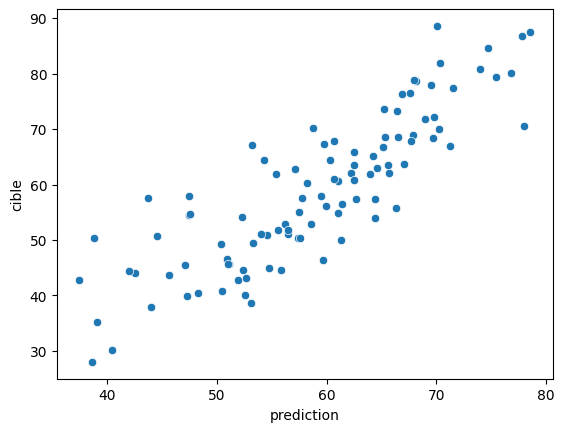

In [ ]:
sns.scatterplot(df_test,x='prediction',y='cible')

In [ ]:
erreur=mean_squared_error(y_test,pred)
print(f'Erreur {erreur}')

Erreur 51.4910758610902


Condons la fonction d'erreur MSE ci-dessous from scratch avec numpy.

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

In [ ]:
erreur=np.sum(np.square(y_test-pred))/len(y_test)
print(f'Erreur {erreur}')

Erreur 51.4910758610902


## Interpretations des des poids

$lr=y=a_1x_1 + a_2x_2 + a_3x_3 + a_4x_4 + a_5x_5 + b$

$lr=y=a_1{pieds\_carres} + a_2{nombre\_chambres} + a_3{nombre\_etages} + a_4{distance\_centre_ville} +a_5{annee\_construction}$ + b

In [ ]:
print(f'Coefficients du modèle {lr.coef_}')
print(f'Intercept du modèle {lr.intercept_}')

Coefficients du modèle [[ 7.01651338  6.97898422  1.75446586 -1.02850524]]
Intercept du modèle [58.04278145]


In [ ]:
for index,obs in enumerate(observations):
    print(f'{obs} => {lr.coef_[0][index]}')
# lr.coef_
# X=data[].values#Observations

pieds_carres => 7.016513381341286
nombre_chambres => 6.9789842174287
nombre_etages => 1.754465864333977
distance_centre_ville => -1.0285052418250773


## Enregistrement manuel des poids modèle

In [ ]:
np.save('weights/lr_coeficients',lr.coef_)
np.save('weights/lr_intercept',lr.intercept_)

In [ ]:
coeficients=np.load('weights/lr_coeficients.npy')
interecpt=np.load('weights/lr_intercept.npy')

In [ ]:
lr_=LinearRegression(n_jobs=3)
lr_.coef_=coeficients
lr_.intercept_=interecpt

In [ ]:
print(f"Dimension d'une seule observation {X_test[0].shape}")
print(f"Observation redimensionner {X_test[0].reshape(-1,X_test[0].shape[0]).shape}")

Dimension d'une seule observation (4,)
Observation redimensionner (1, 4)


In [ ]:
#Résultat avec le modèle dont les poids ont été chargés.
pred_=lr_.predict(X_test[0].reshape(-1,X_test[0].shape[0]))
print(pred_)

[[61.53588688]]


In [ ]:
#Résultat avec le modèle initial.
pred=lr.predict(X_test[0].reshape(-1,X_test[0].shape[0]))
print(pred)

[[63.27367613]]


In [ ]:
#Une autre façon de vérifier si le chargement des poids est effectué correctement.
assert pred_==pred, "Error"